# Nicholas Tam Final Visualization

## Research Question/Interests
Research question: Given the tree dataset, how would we want to arrange the types of trees to be planted in certain locations, such that they could survive and significantly improve the ecosystem?

Given the research question, it would be ideal to analyze relevant properties, such as the relative sizes of each location and the proportions of planted trees for each species.

The following questions will be used as guidelines to supplement the question:
- What are the numbers and proportions of planted trees, by species and genus?
- Which locations within each neighbourhood can host wide varieties of species?
- How do trees that have been planted directly compare in terms of diameter and height to those that have grown naturally?

## Subquestion of interest: What are the numbers and proportions of planted trees, by species and genus?

In [1]:
import altair as alt
import pandas as pd
from toolz.curried import pipe
import os
from pygbif import species

import sys
sys.path.append("../../code")
sys.path.append("../../images")
import data_clean
import preprocess_query_family
import preprocess_query_pollen
import preprocess_change_col_type
import altair_data_transformer
from IPython.display import Image
import geopandas as gpd
import json

In [2]:
# Create a new data transformer that stores the files in a directory
data_dir = 'altairdata'
altair_data_transformer.setup_altair_for_large_data(data_dir)

# Set up file path to save images
viz_folder = '../../images/ntam_viz/'

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('json_dir')

## Processed Data
- Upon loading `public_trees_cleaned.csv`, need to set the attribute types for `HEIGHT_RANGE`, `TREE_ID`, `CIVIC_NUMBER`, and `ON_STREET_BLOCK`.
- `public_trees_planted` is created to filter for species with existing planted trees.

In [3]:
public_trees_cleaned = pd.read_csv("../../data/processed/public_trees_cleaned.csv")
priority_order = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90']
public_trees_cleaned['HEIGHT_RANGE'] = pd.Categorical(public_trees_cleaned['HEIGHT_RANGE'], categories=priority_order, ordered=True)
public_trees_cleaned[['TREE_ID', 'CIVIC_NUMBER', 'ON_STREET_BLOCK']] = public_trees_cleaned[['TREE_ID', 'CIVIC_NUMBER', 'ON_STREET_BLOCK']].astype(str)

public_trees_cleaned.head()

,TREE_ID,CIVIC_NUMBER,STD_STREET,GENUS_NAME,SPECIES_NAME,CULTIVAR_NAME,COMMON_NAME,ON_STREET_BLOCK,ON_STREET,NEIGHBOURHOOD_NAME,...,DIAMETER,DATE_PLANTED,Geom,geo_point_2d,LATITUDE,LONGITUDE,NOMENCLATURE,ON_ADDRESS,FAMILY_NAME,HAS_POLLEN
0,229002,2128,E 54TH AV,FAGUS,SYLVATICA,DAWYCKII,DAWYCK'S BEECH,2100,E 54TH AV,VICTORIA-FRASERVIEW,...,3.0,2014-03-12,"{""coordinates"": [-123.06377300024464, 49.22020...","49.22020099919947, -123.06377300024464",49.220201,-123.063773,FAGUS SYLVATICA,2100 E 54TH AV VICTORIA-FRASERVIEW (EVEN),FAGACEAE,True
1,229005,8443,FREMLIN ST,ACER,TRUNCATUM,PACIFIC SUNSET,PACIFIC SUNSET MAPLE,8400,FREMLIN ST,MARPOLE,...,12.0,2010-11-08,"{""coordinates"": [-123.12751900039063, 49.20967...","49.20967799914094, -123.12751900039063",49.209678,-123.127519,ACER TRUNCATUM,8400 FREMLIN ST MARPOLE (ODD),ACERACEAE,False
2,229013,1407,W 59TH AV,PRUNUS,CERASIFERA,NIGRA,NIGHT PURPLE LEAF PLUM,7400,CARTIER ST,MARPOLE,...,3.0,2010-10-20,"{""coordinates"": [-123.13790199955884, 49.21762...","49.21762499869929, -123.13790199955884",49.217625,-123.137902,PRUNUS CERASIFERA,7400 CARTIER ST MARPOLE (ODD),ROSACEAE,True
3,229015,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,3.0,2009-12-10,"{""coordinates"": [-123.11410500027938, 49.26698...","49.26698999931175, -123.11410500027938",49.266990,-123.114105,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False
4,229016,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,3.0,2009-12-10,"{""coordinates"": [-123.11399200056373, 49.26704...","49.267045998933334, -123.11399200056373",49.267046,-123.113992,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False


In [4]:
planted_species = public_trees_cleaned.loc[public_trees_cleaned['DATE_PLANTED'].notnull(), 'SPECIES_NAME'].unique()
public_trees_planted = public_trees_cleaned[public_trees_cleaned['SPECIES_NAME'].isin(planted_species)]

## Visualization 1: What are the counts and proportions of planted trees?

### Marks
- Bar plot:  
  - Used to accurately display the proportions of planted specimens between species, ordered by total number of specimens.
  - Bar lengths represent proportions of planted specimens for given species, and color differentiation displays the species' total population size.
- Dot plot:
  - Used to provide an interpretable display of the variation in proportions and total populations.
  - Population size is log-transformed to allow for easier interpretation of values given drastic variations in such.

### Channels
- Bar plot: 
  - Position:  
    - Y-axis represents species.
    - X-axis represents the proportions of planted specimens for given species.
  - Color represents the species' total population size, log-transformed, and uses a sequential continuous color palette to display the change in log-transformed total populations, and to display the differences in population sizes should the data be filtered by the widgets.
  - Opacity: Upon brushing on a given range of species, the opacity of all other areas are set to be low, drawing attention to the species under analysis.
  - Tooltip: Displays the corresponding species, genus, proportions of planted specimens and total population size, improving clarity.
- Dot plot:
  - Position:  
    - X-axis represents log-transformed population size, to allow for easier interpretation of values given drastic variations in such.
    - Y-axis represents the proportions of planted specimens for given species.
  - Opacity: Upon brushing on a given range of points, the opacity of all other points are set to be low, drawing attention to the points under analysis.
  - Tooltip: Displays the corresponding species, genus, proportions of planted specimens and total population size, improving clarity.

### Interaction and UI Widgets 
- Genus Dropdown:  
  - Filters trees based on genus, dynamically updating both the histogram and dot plot. 
  - This ensures the user can apply focused comparisons of counts and proportions between similar species.

- Min Total Count Input Box:  
  - Allows users to select a minimum total population size, to ensure that the values displayed have sufficient samples to conduct analyses with.
  - Set to 300 by default.

- Min Proportion and Max Proportion Sliders:
    - Allows users to select minimum and maximum proportions of planted species, to find species that can be used for practical analysis of characteristics between planted and non-planted samples.
    - Set to 0.3 and 0.7 respectively by default.

- Bidirectional Selection:  
  - Users can brush on either plot to filter values on both sides.
  - Species selection from the bar plot, proportion and log-transformed total count from the dot plot. 

- Linked Filtering:  
  - Ensures the bar plot and dot plot remain synchronized. Brushing on either view updates both visualizations, creating a cohesive exploration experience.

- Conditional Highlighting:  
  - Upon brushing into specific marks, the opacity of all other related marks are set to be low, drawing attention to the area under analysis, improving focus and reducing cognitive load.

- Tooltip Enhancements:  
  - Tooltips provide precise numerical values for proportions of planted specimens and total population size corresponding to each species, enhancing interpretability without cluttering the visualization. 

### Tasks Supported by the Visualization
- Retrieve Value: Tooltips allow users to extract specific details, such as proportions of planted specimens and total population size corresponding to each species. 
- Filter: Users can filter data by genus selection (via dropdown), selection of boundaries for population size (via textbox) and proportions of planted specimens (via sliders), and brushing within either plot, enabling focused exploration.
- Compute Derived Value: To obtain the proportion of planted specimens over the total populations for each species, two aggregations were required. The first aggregation involved counting the number of trees with explicit `DATE_PLANTED` values grouped by species, under the assumption that all trees without the `DATE_PLANTED` were not planted trees, while the second involved counting the total number trees for the species that had `DATE_PLANTED` specimens. The proportion was obtained by dividing the number of planted specimens over the total number of specimens for each species.
- Sort: Species in the bar plot are are sorted by population size.

### Why These Choices Were Effective
- Data Processing:  
   - Aggregating proportion of planted specimens over the total populations for each species ensures the visualization is concise and focused on species with sufficiently large amounts of samples to conduct analyses with.  
   - Filtering the dataset avoids overwhelming users with less relevant data while still providing meaningful insights into planted proportions.  

- Comprehensive Analysis:  
   - The bar plot and dot plot visualise variations of proportions of planted specimens across species and population sizes. 
   - Together, they allow users to discover which species has sufficient data for both planted and non-planted specimens through the combinations of the total number of trees and the proportion of planted samples.

- Dynamic Exploration:  
   - The dropdown menu, input box, sliders and bidirectional interactions allow users to explore the data dynamically, refining their analysis based on genus, population size, proportions and species.  
   - Linked filtering ensures consistency between the bar plot and dot plot, maintaining a seamless exploration experience.

- Enhanced Interpretability:  
   - Tooltips and conditional highlighting make the visualization accessible to a wide audience, supporting informed decision-making about species with greater flexibility in terms of what species could be focused on.

In [5]:
species_planted_count = public_trees_planted.groupby(['SPECIES_NAME']).agg(GENUS_NAME=('GENUS_NAME', 'first'),Planted_Count=('DATE_PLANTED', 'count'),).reset_index()
species_total_count = public_trees_planted['SPECIES_NAME'].value_counts().reset_index(name='Total_Count')
species_summary = species_planted_count.merge(species_total_count, on='SPECIES_NAME')
species_summary['Proportion_Planted'] = species_summary['Planted_Count'] / species_summary['Total_Count']
species_summary

,SPECIES_NAME,GENUS_NAME,Planted_Count,Total_Count,Proportion_Planted
0,ABIES,PICEA,37,328,0.112805
1,ACERIFOLIA X,PLATANUS,606,2305,0.262907
2,ACUMINATA,MAGNOLIA,3,28,0.107143
3,ACUTISSIMA,QUERCUS,420,533,0.787992
4,ALBA,MORUS,6,84,0.071429
...,...,...,...,...,...
217,X WAREI,QUERCUS,33,56,0.589286
218,X YEDOENSIS,PRUNUS,2086,2609,0.799540
219,XX,MAGNOLIA,1486,1854,0.801510
220,ZENII,MAGNOLIA,2,2,1.000000


In [6]:
# Dropdown family
list_genus = public_trees_planted['GENUS_NAME'].unique().tolist()
dropdown_genus = alt.binding_select(options=[None] + list_genus, name='Genus: ', labels = ['All'] + list_genus)
selection_genus = alt.selection_point(fields=['GENUS_NAME'], bind=dropdown_genus)
predicate_genus = (selection_genus | (alt.datum.GENUS_NAME == None))

# Input min count
input_box = alt.binding(input="number", name="Min Total Count: ")
filter_total_count = alt.param(name='SelectorName', value=300, bind=input_box)
predicate_mincount = alt.datum.Total_Count >= filter_total_count

# Sliders for Proportion_Planted (min & max)
min_prop_slider = alt.binding_range(min=0, max=1, step=0.01, name="Min Proportion: ")
max_prop_slider = alt.binding_range(min=0, max=1, step=0.01, name="Max Proportion: ")

filter_min_prop = alt.param(name="min_prop_filter", value=0.3, bind=min_prop_slider)
filter_max_prop = alt.param(name="max_prop_filter", value=0.7, bind=max_prop_slider)

predicate_proportion = (alt.datum.Proportion_Planted >= filter_min_prop) & (alt.datum.Proportion_Planted <= filter_max_prop)

# Brushed for bar and scatter plots
brush_bars = alt.selection_interval(encodings=['x'], name="brushBars")  # Select diameter range in histogram
brush_scatter = alt.selection_interval(encodings=['x', 'y'], name="brushScatter")  # Select species in scatter plot

# Bar plot
bar_sum = (
    alt.Chart(species_summary)
    # .transform_calculate(
    #     Proportion_Planted="datum.Planted_Count / datum.Total_Count"
    # )
    .mark_bar()
    .encode(
        alt.X('SPECIES_NAME:N', title='Species', sort='color',),
        alt.Y('Proportion_Planted:Q', title='Proportion', scale=alt.Scale(domain=[0, 1])),
        alt.Color('Total_Count', scale=alt.Scale(type='log', scheme='viridis', reverse=True), title='log_{10}(Total_Count)'),
        opacity=alt.condition(brush_bars, alt.value(1), alt.value(0.1)),
        tooltip=[
            alt.Tooltip("SPECIES_NAME:N", title="Species"),
            alt.Tooltip("GENUS_NAME:N", title="Genus"),
            alt.Tooltip("Proportion_Planted:Q", title="Planted Proportion"),
            alt.Tooltip("Total_Count:Q", title="Total Number of Trees"),
        ]
    ).properties(
        title='Proportions of Planted Trees for Species with Date Data',
    )
    .add_params(selection_genus, filter_total_count, filter_min_prop, filter_max_prop, brush_bars)  # Add interactivity
    .transform_filter(predicate_genus & predicate_mincount & predicate_proportion & brush_scatter)
    .properties(
        title='Proportions of Planted Trees for each Species with Planted Trees',
        height=140, 
        width=1900
    )
) 

# Scatterplot
point_sum = (
    alt.Chart(species_summary).mark_point(filled=True, size=50).encode(
        alt.X('Total_Count', scale=alt.Scale(type='log'), title='log_{10}(Total_Count)'),
        alt.Y('Proportion_Planted:Q', title='Proportion', scale=alt.Scale(domain=[0, 1])),
        opacity=alt.condition(brush_scatter, alt.value(1), alt.value(0.2)),
        tooltip=[
            alt.Tooltip("SPECIES_NAME:N", title="Species"),
            alt.Tooltip("GENUS_NAME:N", title="Genus"),
            alt.Tooltip("Proportion_Planted:Q", title="Planted Proportion"),
            alt.Tooltip("Total_Count:Q", title="Total Number of Trees"),
        ]
    )
    .add_params(selection_genus, filter_total_count, filter_min_prop, filter_max_prop, brush_scatter)  # Add interactivity
    .transform_filter(predicate_genus & predicate_mincount & predicate_proportion & brush_bars)
    .properties(
        title='Proportions against log_{10}(Total Count) for Species with Planted Trees',
        height=300,
    )
)

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/c

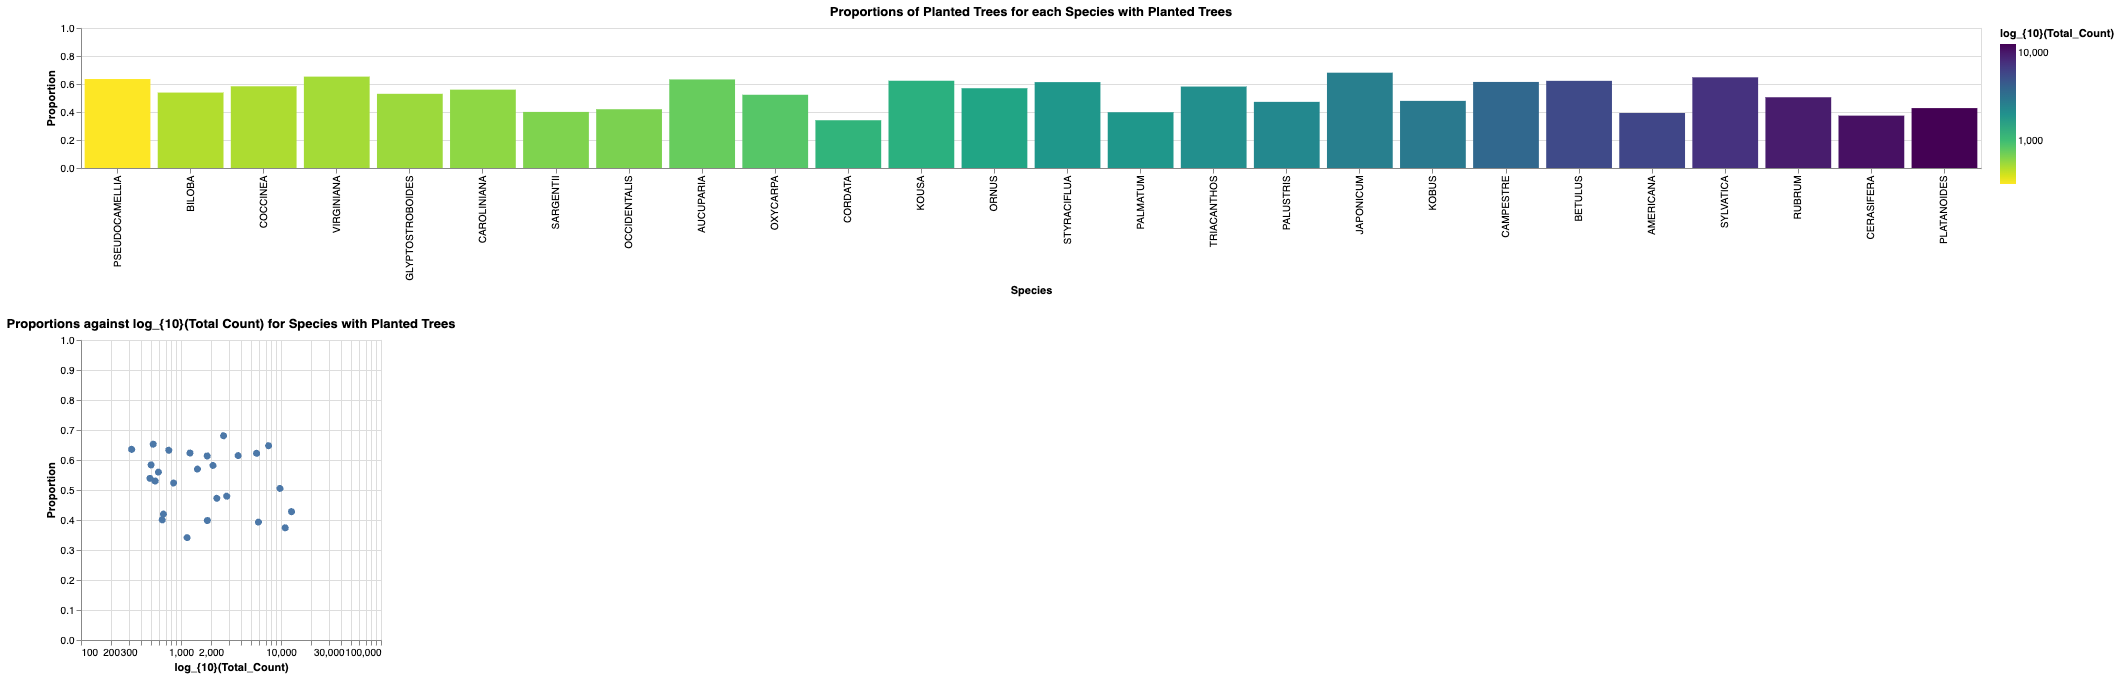

In [7]:
viz1 = (bar_sum & point_sum)
# .configure_view(continuousWidth=900, continuousHeight=140)
viz1.save(viz_folder+'plant_viz1.png')
viz1.save(viz_folder+'plant_viz1.html')
viz1